In [1]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchinfo import summary

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

plt.style.use('seaborn')
%matplotlib inline

In [2]:
seed = 42
n_channels = 1
n_classes = 5
n_epochs = 10
n_workers = 8
img_size = 28
batch_size = 32
learning_rate = 1e-3
weight_decay = 0.0
device = 'mps'
device = torch.device(device)

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    print('Seed set to', seed)
    
    
set_seed(seed)

Seed set to 42


In [4]:
transform = [
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.Pad(2, fill=0),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]

if n_channels == 1:
    transform.append(transforms.Grayscale())

transform = transforms.Compose(transform)
transform

Compose(
    ToTensor()
    Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
    Pad(padding=2, fill=0, padding_mode=constant)
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    Grayscale(num_output_channels=1)
)

In [5]:
train_dataset = ImageFolder('./data/train/', transform=transform)
test_dataset = ImageFolder('./data/test/', transform=transform)

print('\nTrain Dataset:')
print(train_dataset)
print('\nTest Dataset:')
print(test_dataset)

train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              num_workers=n_workers,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             num_workers=n_workers,
                             shuffle=True)


Train Dataset:
Dataset ImageFolder
    Number of datapoints: 7500
    Root location: ./data/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
               Pad(padding=2, fill=0, padding_mode=constant)
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
               Grayscale(num_output_channels=1)
           )

Test Dataset:
Dataset ImageFolder
    Number of datapoints: 2500
    Root location: ./data/test/
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
               Pad(padding=2, fill=0, padding_mode=constant)
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
               Grayscale(num_output_channels=1)
           )


In [6]:
class Net(nn.Module):
    
    def __init__(self, n_channels, n_classes):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(n_channels, 6,
                               kernel_size=5,
                               stride=1,
                               padding='valid')
        self.conv2 = nn.Conv2d(6, 16,
                               kernel_size=5,
                               stride=1,
                               padding='valid')
        self.conv3 = nn.Conv2d(16, 120,
                               kernel_size=5,
                               stride=1,
                               padding='valid')
        
        self.avgpool = nn.AvgPool2d(kernel_size=2,
                                    stride=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(120, 84)
        self.out = nn.Linear(84, n_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.avgpool(x)
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        output = self.out(x)
        return output


model = Net(n_channels, n_classes)
print(summary(model, input_size=(batch_size, n_channels, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 5]                   --
├─Conv2d: 1-1                            [32, 6, 28, 28]           156
├─AvgPool2d: 1-2                         [32, 6, 14, 14]           --
├─Conv2d: 1-3                            [32, 16, 10, 10]          2,416
├─AvgPool2d: 1-4                         [32, 16, 5, 5]            --
├─Conv2d: 1-5                            [32, 120, 1, 1]           48,120
├─Flatten: 1-6                           [32, 120]                 --
├─Linear: 1-7                            [32, 84]                  10,164
├─Linear: 1-8                            [32, 5]                   425
Total params: 61,281
Trainable params: 61,281
Non-trainable params: 0
Total mult-adds (M): 13.52
Input size (MB): 0.13
Forward/backward pass size (MB): 1.67
Params size (MB): 0.25
Estimated Total Size (MB): 2.04


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

model.to(device)
model.eval()
with torch.no_grad():
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        break

print(f'Initial training loss: {loss.item():.4f}')
print(f'Expected initial loss: {-torch.log(1/torch.tensor(n_classes)).item():.4f}')

Initial training loss: 1.6197
Expected initial loss: 1.6094


In [8]:
model.eval()
with torch.no_grad():
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        break

print(f'Initial training accuracy: {(torch.sum(torch.argmax(pred, dim=1) == y) / pred.shape[0] * 100):.4f}%')
print(f'Expected initial accuracy: {(1/n_classes * 100):.4f}%')

Initial training accuracy: 43.7500%
Expected initial accuracy: 20.0000%


In [9]:
batch_iter = iter(train_dataloader)
current_batch = next(batch_iter)
batch_data = [x for x in current_batch]

In [10]:
acci = []
lossi = []

for k in range(n_epochs):
    t0 = time.time()

    model.train()
    for i, data in enumerate(train_dataloader):
        x, y = data
#         x, y = torch.zeros_like(x).to(device), y.to(device)
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        acc = torch.sum(torch.argmax(pred, dim=1) == y) / pred.shape[0]
        lossi.append(loss.item())
        acci.append(acc.item())

        if i % 10 == 0:
            print(k, loss.item(), acc.item())

    t1 = time.time()

    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        total_acc = 0.0
        c = 0
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            
            total_loss += loss_fn(pred, y).item()
            total_acc += (torch.sum(torch.argmax(pred, dim=1) == y) / pred.shape[0]).item()
            c += 1
            break

        test_loss = total_loss / c
        test_acc = total_acc / c

    t2 = time.time()
    
    print('End of epoch', k)
    print(k, test_loss, test_acc, (t1-t0), (t2-t1), (t2-t0))
    print('=' * 80)

0 1.6284115314483643 0.1875
0 1.6022497415542603 0.09375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


0 1.6069881916046143 0.15625
0 1.5662013292312622 0.1875


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


0 1.6105396747589111 0.28125
0 1.5246295928955078 0.40625
0 1.6954782009124756 0.21875
0 1.5677828788757324 0.25
0 1.5889033079147339 0.28125
0 1.6341192722320557 0.09375
0 1.5566140413284302 0.21875
0 1.6088825464248657 0.1875
0 1.5868160724639893 0.15625
0 1.5678906440734863 0.34375
0 1.4785199165344238 0.25
0 1.4105464220046997 0.46875
0 1.364863395690918 0.34375
0 1.4984833002090454 0.34375
0 1.339237928390503 0.46875


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


0 1.5282808542251587 0.375
0 1.4866747856140137 0.3125
0 1.5577657222747803 0.3125
0 1.5884093046188354 0.3125
0 1.5205252170562744 0.40625
End of epoch 0
0 1.455622911453247 0.34375 39.934712171554565 26.2893328666687 66.22404503822327
1 1.4497900009155273 0.375
1 1.4876902103424072 0.375
1 1.6806573867797852 0.1875
1 1.4069058895111084 0.40625


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1 1.4130613803863525 0.34375
1 1.5525609254837036 0.3125
1 1.4413557052612305 0.3125
1 1.6957212686538696 0.1875
1 1.3995368480682373 0.5625
1 1.3638122081756592 0.375
1 1.4634900093078613 0.3125
1 1.4487600326538086 0.3125
1 1.2420426607131958 0.5


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1 1.4288041591644287 0.375
1 1.574072003364563 0.25
1 1.5508276224136353 0.3125
1 1.4709023237228394 0.21875
1 1.3793866634368896 0.5625
1 1.3140380382537842 0.5
1 1.2705938816070557 0.4375
1 1.5915942192077637 0.25


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1 1.4412411451339722 0.28125
1 1.2560689449310303 0.5
1 1.5003118515014648 0.34375
End of epoch 1
1 1.428199052810669 0.4375 40.117820739746094 5.9865782260894775 46.10439896583557
2 1.6957945823669434 0.3125
2 1.432507038116455 0.34375
2 1.4789693355560303 0.375
2 1.4394903182983398 0.46875
2 1.474483847618103 0.375
2 1.4312065839767456 0.3125


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2 1.289449691772461 0.46875
2 1.2885591983795166 0.5
2 1.2450859546661377 0.4375
2 1.2720221281051636 0.4375
2 1.3881232738494873 0.4375
2 1.3391895294189453 0.375
2 1.1805946826934814 0.625
2 1.273101806640625 0.46875
2 1.3210147619247437 0.53125
2 1.334312915802002 0.4375
2 1.534611701965332 0.125
2 1.3190264701843262 0.4375
2 1.2611072063446045 0.53125
2 1.3347909450531006 0.53125
2 1.359660267829895 0.375
2 1.3246792554855347 0.53125
2 1.55972421169281 0.34375
2 1.3669242858886719 0.46875
End of epoch 2
2 1.281731367111206 0.375 40.031198024749756 6.0850019454956055 46.11619997024536
3 1.2319793701171875 0.46875
3 1.4425485134124756 0.3125
3 1.3240749835968018 0.53125
3 1.3742871284484863 0.375
3 1.4763113260269165 0.4375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3 1.3039664030075073 0.4375
3 1.3415948152542114 0.4375
3 1.3071656227111816 0.46875
3 1.4352939128875732 0.375
3 1.5592012405395508 0.375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3 1.2066508531570435 0.53125
3 1.3942742347717285 0.4375
3 1.2531818151474 0.40625
3 1.3340024948120117 0.5


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3 1.4484597444534302 0.375
3 1.2215303182601929 0.4375
3 1.1541411876678467 0.53125
3 1.4783837795257568 0.3125
3 1.2041895389556885 0.625
3 1.6057934761047363 0.3125
3 1.4074773788452148 0.3125
3 1.267549991607666 0.53125
3 1.0743159055709839 0.4375
3 1.0161628723144531 0.59375
End of epoch 3
3 1.4670867919921875 0.3125 39.15376305580139 6.008005142211914 45.161768198013306
4 1.4281702041625977 0.375
4 1.2764222621917725 0.53125
4 1.1784379482269287 0.59375
4 1.211817741394043 0.46875


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


4 1.1325199604034424 0.5
4 1.3016259670257568 0.40625


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


4 1.291580319404602 0.34375
4 1.2710957527160645 0.5
4 1.1772695779800415 0.53125
4 1.3079971075057983 0.4375
4 1.305870532989502 0.46875
4 1.3142125606536865 0.4375
4 1.2181532382965088 0.53125
4 1.1106367111206055 0.46875
4 1.2570157051086426 0.46875
4 1.2953557968139648 0.4375
4 1.230539321899414 0.5
4 1.2729032039642334 0.4375
4 1.6044647693634033 0.28125
4 1.2752878665924072 0.46875
4 1.249237298965454 0.59375
4 1.2123744487762451 0.46875
4 1.2672837972640991 0.5
4 1.4279921054840088 0.53125
End of epoch 4
4 1.3992950916290283 0.46875 39.59336185455322 11.445216178894043 51.038578033447266
5 1.1125397682189941 0.53125
5 1.2519793510437012 0.4375
5 1.2301831245422363 0.59375
5 1.1766605377197266 0.5
5 1.172621726989746 0.53125
5 1.2268714904785156 0.5625
5 1.2232012748718262 0.375
5 1.2039341926574707 0.5


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


5 1.2376253604888916 0.4375
5 1.3640916347503662 0.4375
5 1.2439589500427246 0.4375
5 1.4354305267333984 0.53125
5 1.1870911121368408 0.5
5 1.256202220916748 0.5
5 1.1439704895019531 0.5625
5 1.2855539321899414 0.46875
5 1.3742599487304688 0.46875
5 1.2985053062438965 0.4375
5 1.1360771656036377 0.5625
5 1.236797571182251 0.5625
5 1.2732163667678833 0.53125
5 1.1315016746520996 0.6875
5 1.2935552597045898 0.375
5 1.088477611541748 0.5
End of epoch 5
5 1.3806588649749756 0.34375 39.70970702171326 16.239569902420044 55.9492769241333
6 1.1984009742736816 0.5
6 1.2220430374145508 0.5
6 1.0922714471817017 0.53125
6 1.2249205112457275 0.5625
6 1.2315125465393066 0.46875
6 1.3666692972183228 0.4375
6 1.330749750137329 0.5
6 1.3929686546325684 0.4375
6 1.1919983625411987 0.4375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


6 0.9680312871932983 0.59375
6 0.976432740688324 0.6875
6 1.0866695642471313 0.5
6 1.0632719993591309 0.5625
6 1.1228153705596924 0.5
6 1.2742407321929932 0.46875
6 1.1487733125686646 0.53125
6 1.2812867164611816 0.46875
6 1.0241539478302002 0.53125
6 1.2959048748016357 0.4375
6 1.148866057395935 0.625
6 1.1954209804534912 0.46875
6 1.2691435813903809 0.4375
6 1.206457495689392 0.40625


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


6 1.1956453323364258 0.5
End of epoch 6
6 1.5140708684921265 0.375 39.575326919555664 5.971292972564697 45.54661989212036
7 1.1327242851257324 0.5625
7 1.210961937904358 0.53125
7 1.2670059204101562 0.375
7 1.1248259544372559 0.5625


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7 1.2267327308654785 0.4375
7 1.4430913925170898 0.34375
7 1.1126043796539307 0.5
7 1.5271313190460205 0.375
7 1.0532732009887695 0.59375
7 1.109561800956726 0.59375
7 1.0643738508224487 0.65625
7 0.9574171304702759 0.65625
7 1.1643186807632446 0.59375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7 1.269037127494812 0.40625
7 1.125243902206421 0.5
7 1.1486257314682007 0.5625
7 1.2398717403411865 0.53125
7 1.274019718170166 0.5
7 1.1324241161346436 0.59375
7 1.1349598169326782 0.5625
7 1.1737140417099 0.4375
7 1.251483678817749 0.4375
7 1.1172372102737427 0.4375
7 1.3543953895568848 0.40625
End of epoch 7
7 1.4099397659301758 0.375 39.89585208892822 5.993531942367554 45.889384031295776
8 1.2058154344558716 0.5
8 1.3988637924194336 0.5
8 1.0840528011322021 0.59375
8 1.3442308902740479 0.5
8 1.2065566778182983 0.53125
8 1.0624589920043945 0.65625
8 1.059830665588379 0.5
8 1.0799530744552612 0.53125


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8 1.1186085939407349 0.5
8 0.9367352724075317 0.65625


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8 1.2377779483795166 0.46875
8 1.167241096496582 0.59375
8 1.1368046998977661 0.5
8 0.9482689499855042 0.46875
8 0.912007212638855 0.59375


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8 0.9920068979263306 0.5625
8 1.1295021772384644 0.5
8 1.1342328786849976 0.59375
8 1.3264133930206299 0.4375
8 1.045805811882019 0.5625
8 1.0553395748138428 0.59375
8 1.2624034881591797 0.40625
8 1.2720692157745361 0.46875
8 1.036902904510498 0.75
End of epoch 8
8 1.184818983078003 0.53125 39.44354295730591 5.961359977722168 45.404902935028076
9 1.085347294807434 0.5
9 1.165809154510498 0.5625
9 1.2800731658935547 0.4375
9 1.2845289707183838 0.53125
9 0.9936749935150146 0.5625
9 0.9443953633308411 0.65625
9 1.100579857826233 0.625


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9 1.3907877206802368 0.40625
9 1.1807328462600708 0.5625
9 1.0199934244155884 0.59375
9 1.0831029415130615 0.65625
9 1.170926570892334 0.5
9 0.7856349945068359 0.6875
9 0.9499126076698303 0.59375
9 1.1582489013671875 0.625
9 1.0220279693603516 0.625
9 0.9023980498313904 0.75
9 1.0829501152038574 0.59375
9 1.1900900602340698 0.53125
9 1.2963812351226807 0.5625
9 1.1716567277908325 0.53125
9 1.342077612876892 0.46875
9 1.0614027976989746 0.53125


/Users/gautam/miniforge3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9 1.381074070930481 0.4375
End of epoch 9
9 1.4520084857940674 0.34375 39.454190731048584 5.9327802658081055 45.38697099685669


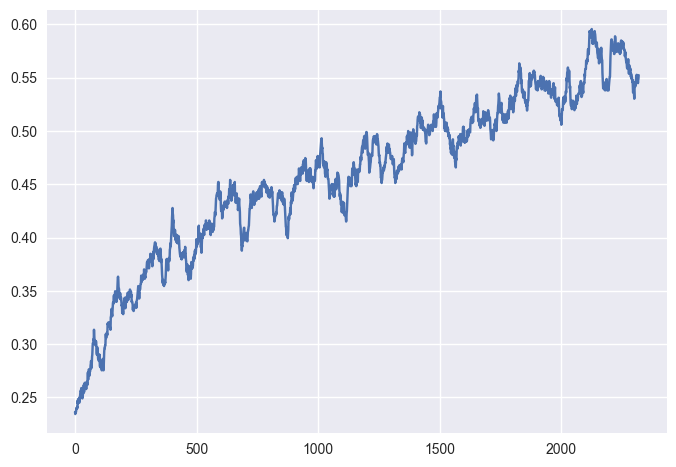

In [11]:
plt.plot(F.avg_pool1d(torch.tensor([acci]), kernel_size=batch_size, stride=1).view(-1,));

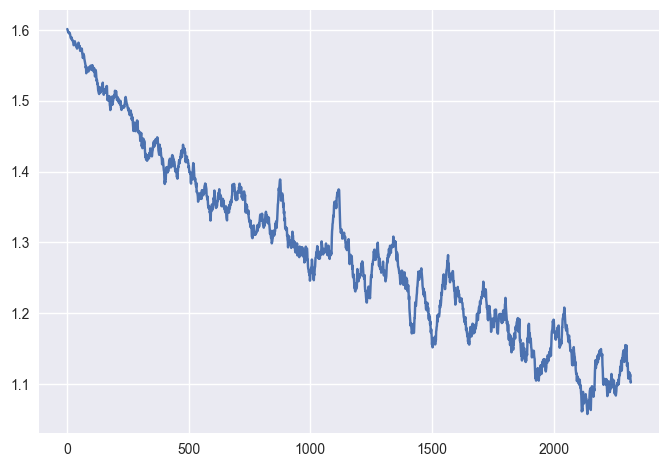

In [12]:
plt.plot(F.avg_pool1d(torch.tensor([lossi]), kernel_size=batch_size, stride=1).view(-1,));

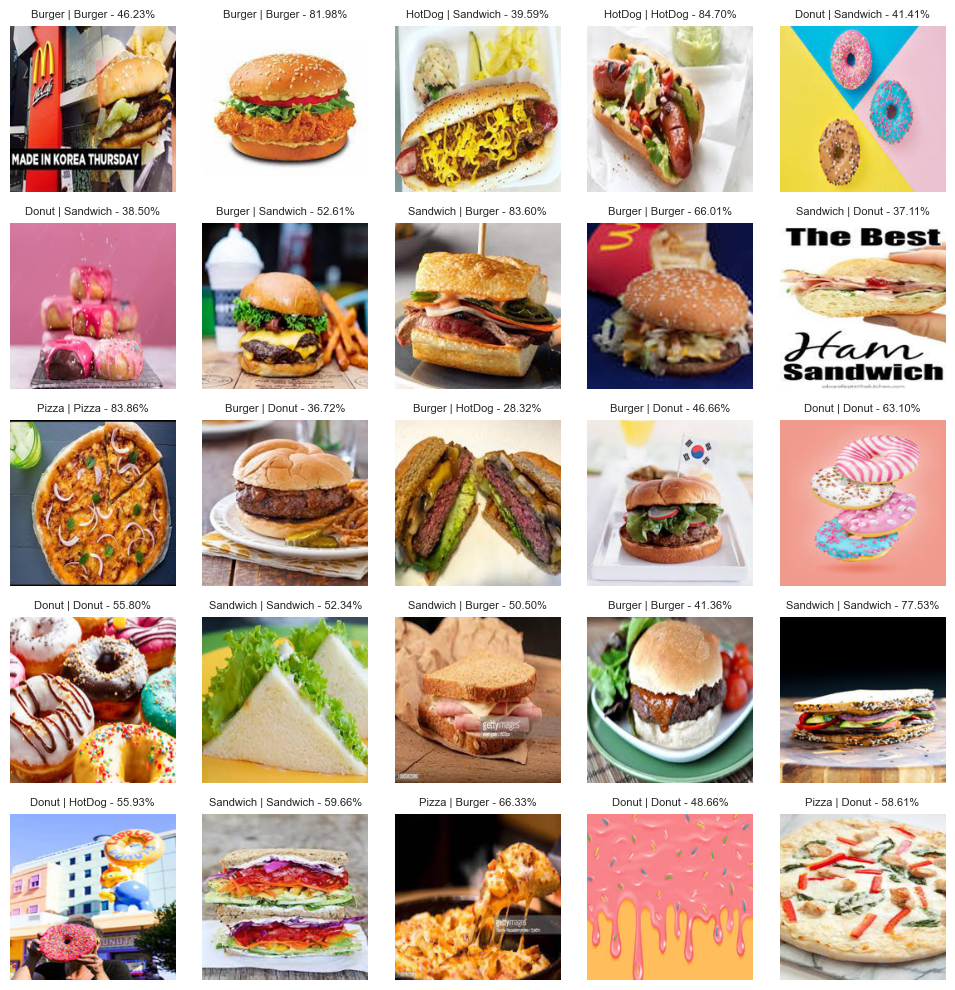

In [13]:
random_dataset = random.sample(test_dataset.imgs, 25)
idx_to_class = {v:k for k, v in test_dataset.class_to_idx.items()}
data = []

with torch.no_grad():
    model.eval()
    for x, y in random_dataset:
        img = Image.open(x)
        img_t = transform(img).to(device)
        img_t = torch.unsqueeze(img_t, dim=0)
        pred = model(img_t)
        probs = F.softmax(pred, dim=1)
        pred_idx = torch.argmax(pred, dim=1).item()
        pred_class = idx_to_class[pred_idx]
        y_class = idx_to_class[y]
        data.append((x, pred_class, probs[0][pred_idx].item(), y_class))

nrows = int(25**0.5)
plt.figure(figsize=(10, 10))
for i in range(1, 25 + 1):
    plt.subplot(nrows, nrows, i)
    img = Image.open(data[i-1][0])
    img = img.resize((200, 200))
    plt.title(f'{data[i-1][3]} | {data[i-1][1]} - {data[i-1][2]*100:.2f}%', size=8)
    plt.imshow(img)
    plt.grid()
    plt.axis('off')
    plt.tight_layout();

In [37]:
model.train()
x = torch.randn((batch_size, 1, 32, 32), device=device); x.requires_grad = True
out = model(x)
loss = out[2].sum()
loss.backward()

for i in range(batch_size):
    if i != 2:
        assert (x.grad[i] == 0).all()
    else:
        assert (x.grad[i] != 0).any()